In [ ]:
import numpy as np 
import pandas as pd 
from google.colab import drive
drive.mount('/content/drive')
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import acf
from math import sqrt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_clinical_data = pd.read_csv("/content/drive/My Drive/IDMP/train_clinical_data.csv")
train_peptides = pd.read_csv("/content/drive/My Drive/IDMP/train_peptides.csv")
train_protiens = pd.read_csv("/content/drive/My Drive/IDMP/train_proteins.csv")
supplemental_clinical_data = pd.read_csv("/content/drive/My Drive/IDMP/supplemental_clinical_data.csv")
train = train_clinical_data.append(supplemental_clinical_data,ignore_index=True)

<ipython-input-26-df6c587c39bd>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train_clinical_data.append(supplemental_clinical_data,ignore_index=True)


In [ ]:
train

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On
...,...,...,...,...,...,...,...,...
4833,65382_0,65382,0,NaN,NaN,0.0,NaN,NaN
4834,65405_0,65405,0,5.0,16.0,31.0,0.0,NaN
4835,65405_5,65405,5,NaN,NaN,57.0,NaN,NaN
4836,65530_0,65530,0,10.0,6.0,24.0,0.0,NaN


In [ ]:
obs_count = train.groupby("patient_id")['updrs_1'].count()
max_obs_patient = obs_count.idxmax()
print("Patient with the highest number of observations:", max_obs_patient)

Patient with the highest number of observations: 15009


In [ ]:
df_15009 = train[train['patient_id'] == 15009]

In [ ]:
df_15009_final = df_15009[['visit_id','updrs_1']]

In [ ]:
len(df_15009_final)

17

In [ ]:
train_df = df_15009_final[:14]
train_df

,visit_id,updrs_1
579,15009_0,8.0
580,15009_3,7.0
581,15009_6,10.0
582,15009_9,5.0
583,15009_12,4.0
584,15009_18,4.0
585,15009_24,5.0
586,15009_30,5.0
587,15009_36,5.0
588,15009_42,4.0


In [ ]:
test_df = df_15009_final.iloc[-3:, :]
test_df

,visit_id,updrs_1
593,15009_84,10.0
594,15009_96,18.0
595,15009_108,12.0


In [ ]:
result = adfuller(train_df['updrs_1'])
print(f'Test Statistic: {result[0]}')
print(f'p-value: {result[1]}')

Test Statistic: -3.044229821894477
p-value: 0.030965294337072936


<Axes: xlabel='visit_id'>

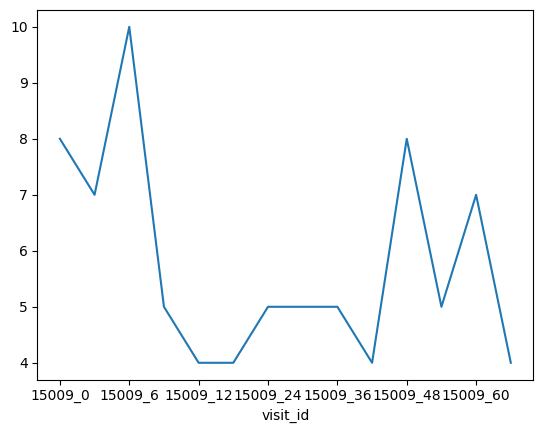

In [ ]:
train_df = train_df.set_index('visit_id')
train_df['updrs_1'].plot()

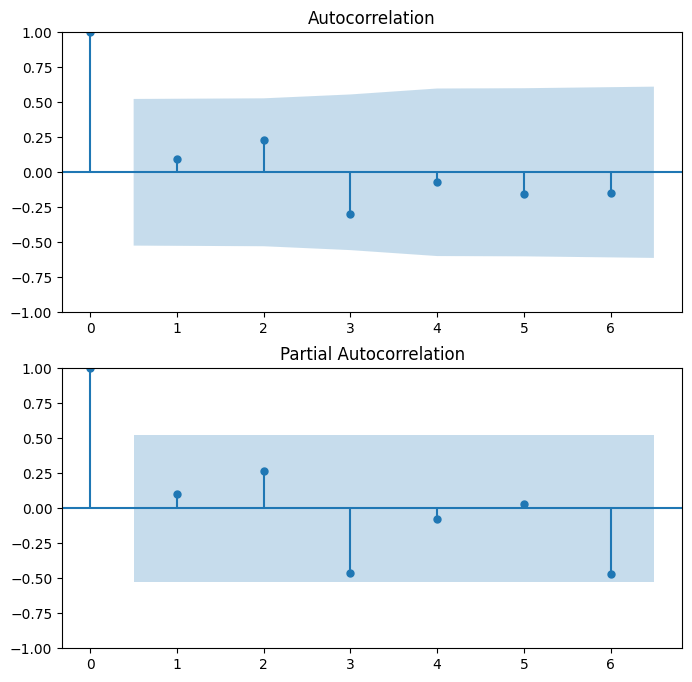

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
plot_acf(train_df, ax=ax1, lags=6)
plot_pacf(train_df, ax=ax2, lags=6)
plt.show()

In [ ]:
model = sm.tsa.ARIMA(train_df, order=(4, 0, 5))
results = model.fit()

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likeliho

In [ ]:
preds = results.forecast(steps=len(test_df))
preds = pd.DataFrame(preds)

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
preds['visit_id'] = ["15009_84","15009_96","15009_108"]

In [ ]:
preds = preds.set_index('visit_id')

In [ ]:
test_df

,visit_id,updrs_1
593,15009_84,10.0
594,15009_96,18.0
595,15009_108,12.0


In [ ]:
mae = mean_absolute_error(test_df['updrs_1'], preds)
rmse = sqrt(mean_squared_error(test_df['updrs_1'], preds))

print("Mean absolute error: ", mae)
print("Root mean squared error: ", rmse)

Mean absolute error:  7.61981735564721
Root mean squared error:  8.619919963270238


In [ ]:
test_df = test_df.set_index('visit_id')

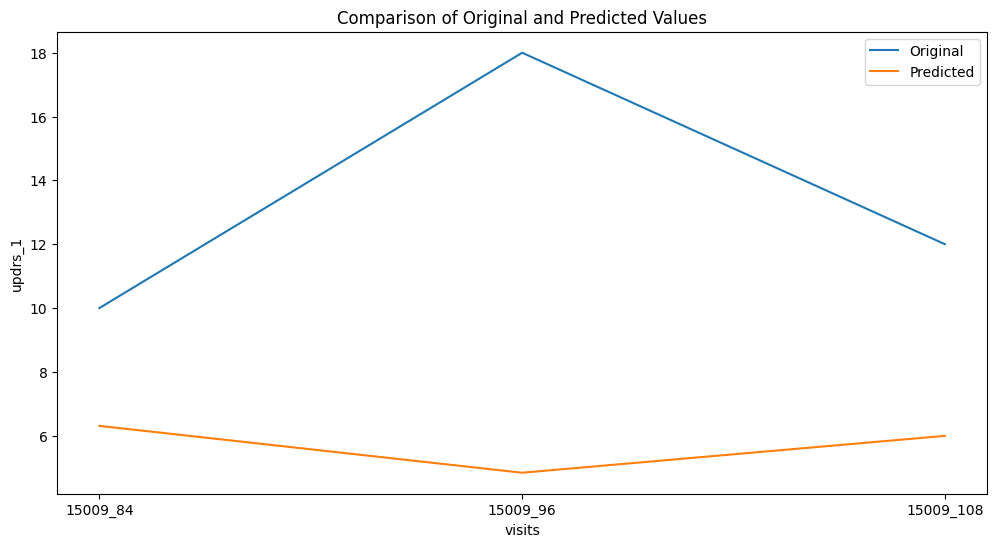

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(test_df.index, test_df.values, label='Original')
plt.plot(preds.index, preds.values, label='Predicted')
plt.title('Comparison of Original and Predicted Values')
plt.xlabel('visits')
plt.ylabel('updrs_1')
plt.legend()
plt.show()